*Unresolved Question*
1. How Batch Normalization works with Convolution layers?
2. Does Batch Normalization applied features wise or row wise?
    - `For tabuler data - feature wise`
    - `For Image - Channel wise`
---

### Internal Covariate Shift: The "Shifting Sand" Problem in Neural Networks

Imagine you're teaching a group of students to solve math problems. Every day, you change the rules:
- **Monday:** Problems use only positive numbers  
- **Tuesday:** Problems suddenly include decimals  
- **Wednesday:** Problems switch to algebra  

Students struggle because the **foundation keeps shifting**. This is exactly what happens inside neural networks without batch normalization—it's called **Internal Covariate Shift (ICS)**.

---

### What is Internal Covariate Shift?
**Definition:**  
The change in *distribution of inputs* to deeper layers in a neural network caused by weight updates during training. Each layer constantly adapts to a moving target.

#### Key Problem:
- Layer 1 updates its weights → changes its output distribution  
- This shifted output becomes Layer 2's input → Layer 2 must relearn  
- Cascades through all layers → **slow/unstable training**

---

### Why It Happens: The Domino Effect
Consider a 3-layer network processing images:
1. **Initial state:**  
   - Layer 1 outputs values centered around 0.5  
   - Layer 2 learns weights for inputs ~0.5  

2. **After weight update:**  
   - Layer 1 now outputs values centered around 2.3  
   - Layer 2's weights are **obsolete**—designed for 0.5, not 2.3!  

3. **Result:**  
   - Layer 2 scrambles to adjust → slows learning  
   - Gradients become unstable (explode/vanish)  
 
*`Distribution shift between layers during training`*

---

### How Batch Normalization Fixes ICS
BatchNorm acts like a `stabilizer` between layers. Here's how it works for any layer:

#### Step 1: Standardize Inputs (Per Mini-Batch)
For each input feature to the layer:  
- **Compute mean (μ) and variance (σ²)** across the batch  
- **Normalize:**  
  ```
  x̂ = (x - μ) / √(σ² + ε)   // ε=tiny number for stability
  ```  
  → Forces inputs to mean=0, variance=1  

#### Step 2: Learnable Scaling  
- **Add flexibility:**  
  ```
  y = γ * x̂ + β  
  ```  
  - γ (gamma) scales the standard deviation  
  - β (beta) shifts the mean  
  → Allows the network to *choose* optimal distribution  

---

### Intuition Through Analogy
**Without BatchNorm:**  
- Like students solving problems on a wobbly desk (shifting inputs)  
- Hard to focus—constantly adjusting to instability  

**With BatchNorm:**  
1. **Standardization:**  
   - Nails the desk to the floor (stable foundation)  
2. **Gamma/Beta:**  
   - Lets students *tilt* the desk if needed (γ/β adapt to optimal angle)  

→ Students now learn faster because they're not fighting instability  

---

### Why This Matters
| **Problem**         | **BatchNorm Solution**       | **Effect**                  |
|---------------------|------------------------------|-----------------------------|
| Inputs shift wildly | Forces mean=0, variance=1    | Stable inputs to next layer |
| Slow convergence    | Smoother loss landscape      | Faster training             |
| Gradient explosion  | Controls value magnitudes    | -                           |

---

### Limitations & Tradeoffs
- BatchNormalization works well for standard neural networks (ANNs) but faces challenges in Recurrent Neural Networks (RNNs) and Transformers. This is because RNNs process sequences where padding (adding zeros to make sequences equal length) is common. When applying BatchNorm feature-wise to padded sequences, the calculated mean and standard deviation become skewed due to these artificial zero values, making them poor representatives of the true data distribution.
<br>
Alternatives - `LayerNorm (RNNs), InstanceNorm (style transfer)` 

- Neural network makes slower predictions due to the extra computations required at each layer. Fortunately, it’s often possible to fuse the BN layer with the previous layer after training, thereby avoiding the runtime penalty. This is done by updating the previous layer’s weights and biases so that it directly produces outputs of the appropriate scale and offset. For example, if the previous layer computes `XW + b`, then the BN layer will compute `γ ⊗ (XW + b – μ) / σ + β` (ignoring the smoothing term ε in the denominator). If we define `W′ = γ⊗W / σ` and `b′ = γ ⊗ (b – μ) / σ + β`, the equation simplifies to `XW′ + b′`. So, if we replace the previous layer’s weights and biases (W and b) with the updated weights and biases (W′ and b′), we can get rid of the BN layer (`TFLite’s converter does this automatically`)

*You may find that training is rather slow, because each epoch takes much more time when you use batch normalization. This is usually counterbalanced by the fact that convergence is much faster with BN, so it will take fewer epochs to reach the same performance.*

---

### Why "Covariate Shift"?
- **Covariate** = Input variable (e.g., pixel values)  
- **Shift** = Change in statistical distribution  
- **Internal** = Happening *inside* the network (not at raw input)  

BatchNorm is the ultimate stabilizer—turning shifting sand into solid concrete for faster, deeper networks! 🏗️

In [1]:
# Importing Modules
import tensorflow as tf
from tensorflow import keras
from keras.datasets import fashion_mnist
from keras import Sequential
from keras.layers import Dense, Input, BatchNormalization, Activation, Flatten

In [2]:
# Loading the dataset
(X_train, y_train), (X_test, y_test) = fashion_mnist.load_data()

29515/29515 ━━━━━━━━━━━━━━━━━━━━ 0s 3us/step
26421880/26421880 ━━━━━━━━━━━━━━━━━━━━ 8s 0us/step
5148/5148 ━━━━━━━━━━━━━━━━━━━━ 0s 1us/step
4422102/4422102 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


In [6]:
# Copying the data
X_train_cpy = X_train
y_train_cpy = y_train
X_test_cpy = X_test
y_test_cpy = y_test

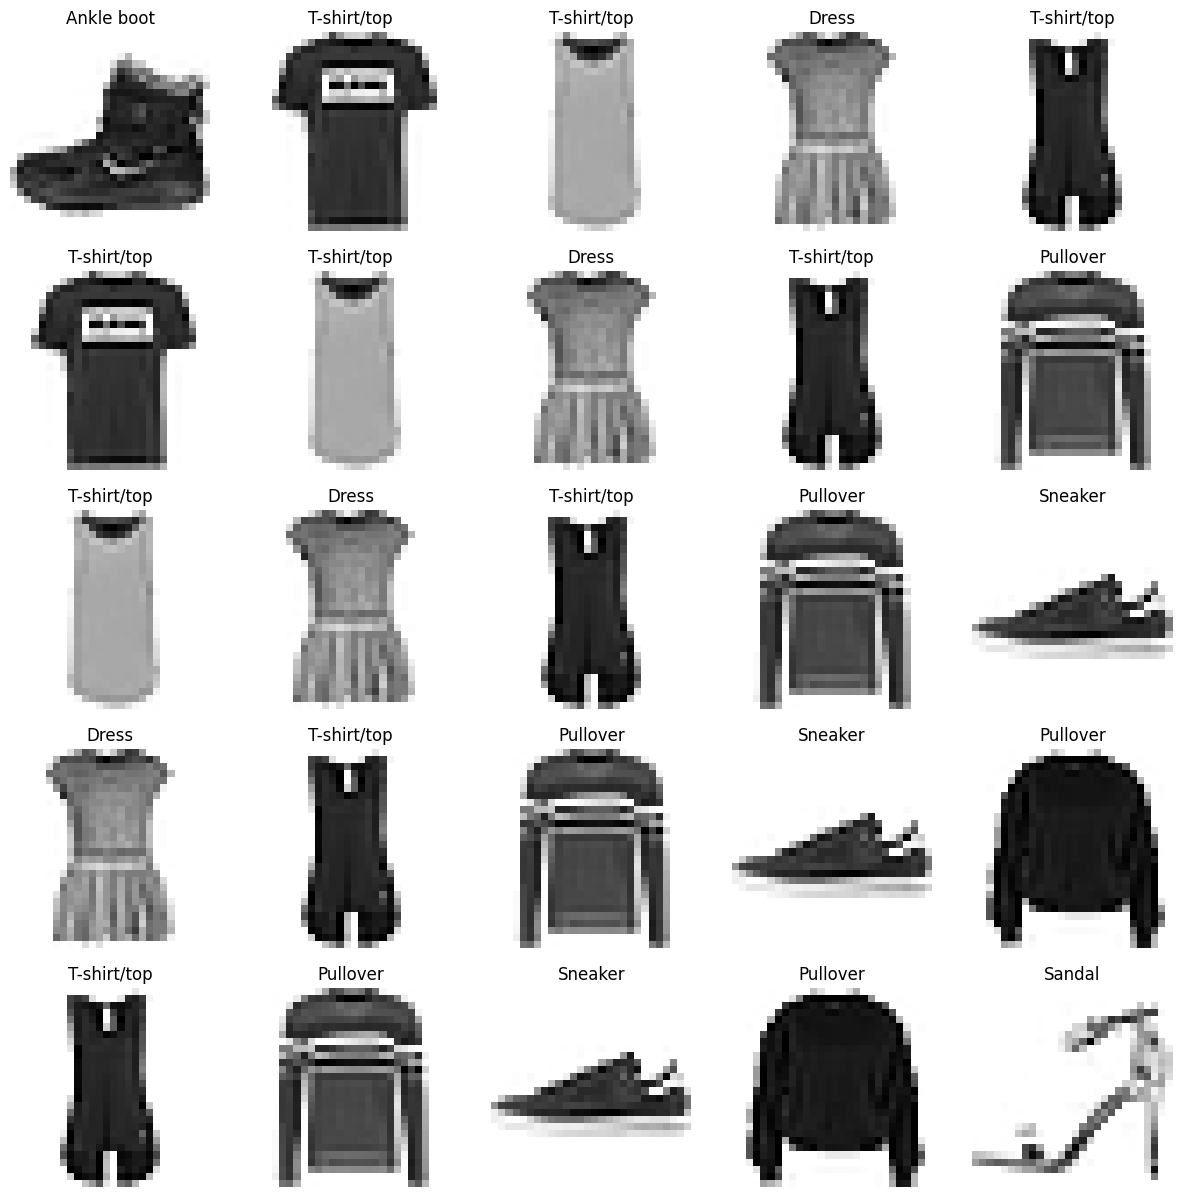

In [20]:
import matplotlib.pyplot as plt
import seaborn as sns

class_labels = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
                'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

fig, ax = plt.subplots(nrows=5, ncols=5, figsize=(15, 15))
for row in range(5):
    for col in range(5):
        sns.heatmap(
            X_train_cpy[row + col, :, :],
            cmap='binary',
            cbar=False,
            xticklabels=False,
            yticklabels=False,
            ax=ax[row, col]
        )
        ax[row, col].set_title(class_labels[y_train[row + col]])

In [25]:
# Model Building
model = Sequential([
    Input(shape = [28, 28], batch_size = 32),
    Flatten(),
    Dense(units = 300, activation = 'relu'),
    BatchNormalization(),
    Dense(units = 100, activation = 'relu'),
    BatchNormalization(),
    Dense(units = 10, activation = 'sigmoid')
])

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten (Flatten)               │ (32, 784)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (32, 300)              │       235,500 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (32, 300)              │         1,200 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (32, 100)              │        30,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (32, 100)              │           400 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (32, 10)               │         1,010 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 268,210 (1.02 MB)

 Trainable params: 267,410 (1.02 MB)

 Non-trainable params: 800 (3.12 KB)

In [26]:
model.compile(
    optimizer = 'Adam',
    loss = 'sparse_categorical_crossentropy',
    metrics = ['accuracy']
)

In [27]:
model.fit(X_train, y_train, batch_size = 32, epochs = 10, validation_data = (X_test, y_test))

Epoch 1/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 13s 5ms/step - accuracy: 0.8265 - loss: 0.4783 - val_accuracy: 0.8489 - val_loss: 0.4303
Epoch 2/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 10s 5ms/step - accuracy: 0.8586 - loss: 0.3878 - val_accuracy: 0.8546 - val_loss: 0.5446
Epoch 3/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 10s 5ms/step - accuracy: 0.8705 - loss: 0.3511 - val_accuracy: 0.8438 - val_loss: 0.5701
Epoch 4/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 10s 5ms/step - accuracy: 0.8779 - loss: 0.3320 - val_accuracy: 0.8582 - val_loss: 0.5502
Epoch 5/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 10s 6ms/step - accuracy: 0.8823 - loss: 0.3165 - val_accuracy: 0.8680 - val_loss: 0.8324
Epoch 6/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 20s 5ms/step - accuracy: 0.8881 - loss: 0.2996 - val_accuracy: 0.8734 - val_loss: 0.6043
Epoch 7/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 10s 6ms/step - accuracy: 0.8921 - loss: 0.2904 - val_accuracy: 0.8697 - val_loss: 0.9415
Epoch 8/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 10s 5ms/step - accuracy: 0.8939 - loss: 0

### Training vs. Inference: The Problem

During **training**, BatchNorm calculates the mean (μ) and standard deviation (σ) **from the current mini-batch**. This is dynamic and changes with every batch.

During **inference**, we don't have mini-batches in the same way (we might get a single sample, not a batch). We need a fixed, reliable estimate.

### The Solution: Running (Population) Statistics

Instead of using batch statistics, BatchNorm uses **running averages** of the mean and variance it observed during training.

**How it works:**

1.  **During Training:** For every mini-batch, the layer:
    *   Calculates the batch mean (μ_batch) and variance (σ²_batch).
    *   **Updates the running averages** using these values:
        *   `running_mean = momentum * running_mean + (1 - momentum) * μ_batch`
        *   `running_variance = momentum * running_variance + (1 - momentum) * σ²_batch`
    *   (Where `momentum` is a hyperparameter, typically close to 0.9 or 0.99, which controls how much to keep from the past).

2.  **During Inference:** The layer **stops calculating new statistics**. It simply uses the final, learned `running_mean` and `running_variance` values (often called the "population statistics") to normalize *any* input it receives.
    *   `normalized_input = (input - running_mean) / sqrt(running_variance + ε)`

### In Short:

| Phase | How it gets Mean & Std | Why? |
| :--- | :--- | :--- |
| **Training** | From the **current mini-batch**. Also updates **running averages**. | To stabilize training and learn the statistics. |
| **Inference** | From the final **running averages** learned during training. | To get a **stable, fixed** normalization for any input, ensuring consistent behavior. |

This ensures the model's behavior is consistent and deterministic after it's deployed.

In [53]:
# Batch Normalization before activation
model = Sequential()

model.add(Input(shape = [28, 28], batch_size = 32))
model.add(Flatten())
model.add(BatchNormalization())
model.add(Dense(units = 300))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dense(units = 100))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dense(units = 10, activation = 'sigmoid'))

model.summary()

Model: "sequential_16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ flatten_1 (Flatten)                  │ (32, 784)                   │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_36               │ (32, 784)                   │           3,136 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_51 (Dense)                     │ (32, 300)                   │         235,500 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_37               │ (32, 300)                   │           1,200 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation (Activation)              │ (32, 300)                   │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_52 (Dense)                     │ (32, 100)                   │          30,100 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_38               │ (32, 100)                   │             400 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_1 (Activation)            │ (32, 100)                   │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_53 (Dense)                     │ (32, 10)                    │           1,010 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 271,346 (1.04 MB)

 Trainable params: 268,978 (1.03 MB)

 Non-trainable params: 2,368 (9.25 KB)

> ### Some Important Practices
> - The authors of the BN paper argued in favor of adding the BN layers before the activation functions, rather than after (as we just did). `There is some debate about this, as which is preferable seems to depend on the task—you can experiment with this too to see which option works best on your dataset.` To add the BN layers before the activation function, you must remove the activation functions from the hidden layers and add them as separate layers after the BN layers. 
> - Moreover, since a `batch normalization layer includes one offset parameter per input, you can remove the bias term from the previous layer` by passing use_bias=False when creating it.

In [54]:
model.compile(
    optimizer = 'Adam',
    loss = 'sparse_categorical_crossentropy',
    metrics = ['accuracy']
)

In [55]:
model.fit(X_train, y_train, batch_size = 32, epochs = 10, validation_data = (X_test, y_test))

Epoch 1/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 20s 9ms/step - accuracy: 0.8073 - loss: 0.5515 - val_accuracy: 0.8613 - val_loss: 0.3913
Epoch 2/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 19s 9ms/step - accuracy: 0.8689 - loss: 0.3511 - val_accuracy: 0.8735 - val_loss: 0.3513
Epoch 3/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 16s 9ms/step - accuracy: 0.8826 - loss: 0.3147 - val_accuracy: 0.8787 - val_loss: 0.3392
Epoch 4/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 17s 9ms/step - accuracy: 0.8926 - loss: 0.2921 - val_accuracy: 0.8811 - val_loss: 0.3294
Epoch 5/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 18s 10ms/step - accuracy: 0.8976 - loss: 0.2746 - val_accuracy: 0.8828 - val_loss: 0.3279
Epoch 6/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 19s 9ms/step - accuracy: 0.9016 - loss: 0.2634 - val_accuracy: 0.8853 - val_loss: 0.3542
Epoch 7/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 16s 9ms/step - accuracy: 0.9111 - loss: 0.2365 - val_accuracy: 0.8917 - val_loss: 0.3311
Epoch 8/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 20s 9ms/step - accuracy: 0.9164 - loss: 

### The Problem: The "Forced" Normalization

Remember what the first step of BatchNorm does:
1.  It takes a batch of data for a layer.
2.  It calculates the mean (`μ`) and variance (`σ²`) of that batch.
3.  It **forces** the data to have a standard normal distribution: `mean = 0`, `variance = 1`.
    *   `x_hat = (x - μ) / √(σ² + ε)`

**But here's the critical issue:** What if a standard normal distribution (mean 0, variance 1) isn't the *best* distribution for the data to have for the network to learn? What if the optimal distribution has a different mean and variance?

For example, if you use a **sigmoid** activation function after the BatchNorm layer, its most "active" and useful region is *not* around 0. For sigmoid, the linear region is roughly between -2 and 2. For a **ReLU** activation, the optimal distribution might be centered slightly positively.

By *forcing* the data to mean 0 and variance 1, we might be:
*   **Removing useful information** from the previous layer.
*   **Slowing down learning** by making the activation functions operate in their less sensitive regions.

---

### The Solution: The "Learnable Undo" (Gamma and Beta)

This is where `γ` (gamma) and `β` (beta) come in. They are **learnable parameters** that give the network two powerful knobs to turn:

1.  **Beta (β)**: The **Shift** parameter (controls the mean)
    *   It adds a learned value to the normalized data: `y = γ * x_hat + β`
    *   If the network learns that the data should have a mean of `0.5` instead of `0`, it can set `β = 0.5`.
    *   **Analogy:** After the BatchNorm "machine" centers the data at 0, `β` says, "Actually, let's shift everything to the right by 0.5."

2.  **Gamma (γ)**: The **Scale** parameter (controls the variance)
    *   It multiplies the normalized data by a learned value.
    *   If the network learns that the data should have a wider spread (variance > 1), it can set `γ` to a value greater than 1 (e.g., `γ = 1.5`).
    *   If it needs a tighter spread (variance < 1), it can set `γ` to a value less than 1 (e.g., `γ = 0.5`).
    *   **Analogy:** After the BatchNorm "machine" squishes the data to a standard spread, `γ` says, "Actually, let's stretch it out a bit more" or "Let's squish it even further."

The final, brilliant output of a BatchNorm layer is:
**`y = γ * x_hat + β`**

This `y` is what gets passed to the next layer or the activation function.

---

### A Simple Analogy: The Perfect Fit Tailor

Imagine Batch Normalization is a **standard-sized clothing rack**. All clothes are forced to be a single, average size (Mean 0, Variance 1). This is better than having wildly different sizes, but it won't fit anyone perfectly.

*   **Gamma (γ)** is like taking the standard-sized shirt and **letting out the seams or taking them in** to adjust how *loose* or *tight* it is (the scale/variance).
*   **Beta (β)** is like **adding padding to the shoulders or shortening the sleeves** to adjust where the shirt sits on the body (the shift/mean).

The network is the "customer." During training, it learns the perfect `γ` and `β` for each batch norm layer, "tailoring" the standard-sized output to its exact needs.

### Why This is So Important: Flexibility and Representation Power

1.  **The Network Can "Undo" BatchNorm:**
    This is the most important point. If the network discovers that normalizing the data isn't helpful for a particular layer, it can easily learn to reverse it.
    *   It can set `γ = √(σ² + ε)` and `β = μ`
    *   The output then becomes: `y = √(σ² + ε) * x_hat + μ = x`
    *   **It perfectly reconstructs the original input!** This means that if batch normalization isn't useful, the network can learn to effectively turn it off. This makes adding BatchNorm a virtually risk-free operation.

2.  **Preserves Non-Linearity:**
    The network can learn the optimal distribution to feed into the next non-linear activation function (Sigmoid, ReLU, etc.), ensuring the model's expressive power is maintained and even enhanced.

3.  **Learns the Optimal Data Distribution:**
    Instead of being forced into a one-size-fits-all distribution, each BatchNorm layer learns the best possible distribution for the task at hand, leading to faster and better learning.

### Summary Table

| Parameter | Symbol | What it Does | Analogy | If it learns... |
| :--- | :--- | :--- | :--- | :--- |
| **Beta** | `β` | **Shifts** the data. Controls the **mean**. | Adjusting the center point. | `β = 0.5` -> New mean is 0.5. |
| **Gamma** | `γ` | **Scales** the data. Controls the **variance**. | Adjusting the spread. | `γ = 2.0` -> New variance is 4.0. |

**In a nutshell:** `γ` and `β` transform Batch Normalization from a rigid, forced standardization into a flexible, learnable layer. They allow the network to **learn the ideal mean and variance** for the normalized data at each layer, balancing the stability of normalization with the expressive power needed for complex learning. This is why they are indispensable.